In [1]:
#!pip install --upgrade git+https://github.com/keras-team/keras-cv

In [2]:
#!pip install -q --upgrade keras-cv
#!pip install -q --upgrade keras  # Upgrade to Keras 3.

In [3]:
#!wget "https://universe.roboflow.com/ds/UZFvFHcTp4?key=Ba0HgFQwHR" -O indoor_object_detection.zip
#!unzip "indoor_object_detection.zip" -d "dataset3/"

In [4]:
#!wget https://universe.roboflow.com/ds/GG1XJhlbDK?key=FFxqUqVjub -O indoor_object_detection.zip
#!unzip "indoor_object_detection.zip" -d "dataset1/"

## Setup

In [5]:
import os
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
import keras
import keras_cv
from keras_cv import visualization
from keras_cv import bounding_box
from keras_cv.layers import Mosaic, Resizing
import datetime
import pickle

import random
import cv2
import uuid

/home/andrea/tfenvl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-10 18:35:36.167704: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-10 18:35:36.303046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 18:35:36.303085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 18:35:36.314620: E e

Using TensorFlow backend


In [6]:
# per bypassare messaggi di warning relativi all'implementazione dei layer di Data-Augmentation
tf.get_logger().setLevel('ERROR')

# impostazione per TensorFlow in modo che non allochi tutta
# la memoria della GPU ma solo quella necessaria, in modo da
# poter lanciare altri addestramenti in parallelo a questo
physical_devices = tf.config.list_physical_devices('GPU')
for pd in physical_devices:
   try:
     tf.config.experimental.set_memory_growth(pd, True)
   except:
     # device non valida/compatibile
     pass

2024-03-10 18:35:40.116867: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 18:35:40.211268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 18:35:40.211422: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Hyperparameters

In [7]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 1.000e-03
EPOCH = 100
INITIAL_EPOCH = 0
GLOBAL_CLIPNORM = 10.0
bestResult = -1 # best MaP of previous session (-1 for new session)

DATASET_NAME = "animali"
BACKBONE_SIZE = "s"
BACKBONE_NAME ="yolo_v8_" + BACKBONE_SIZE + "_backbone_coco"
BACKBONE_TRAINABLE = False
BACKBONE_UNFREEZE = False

MODEL_NAME = "model-augment-{size}{freezed}-{dataset}".format(size=BACKBONE_SIZE, freezed= "-bbfreez" if BACKBONE_TRAINABLE == False else "", dataset=DATASET_NAME)
HISTORY_NAME = MODEL_NAME + "-history"

#load previous training best result
if os.path.isfile(MODEL_NAME + ".pkl"):
    with open(MODEL_NAME + ".pkl", 'rb') as f:
        loaded_dict = pickle.load(f)
        bestResult = loaded_dict["BestMap"].numpy()
print(F"using best MaP: {bestResult}")

# Path to images and annotations
path_train = F"../{DATASET_NAME}/train/"
path_valid = F"../{DATASET_NAME}/valid/"

# elements to use for debug callbacks (use 0 in real train process)
debug_size_train = 0
debug_size_valid = debug_size_train * SPLIT_RATIO

class_ids = [
    #"TV", "bed", "chair", "clock", "console", "consoleeeeee", "door", "fan", "light", "sofa", "switchboard", "table"
    #"emptychair", "fullchair"
    #"Chair","Sofa","Table"
    "Cane", "Gatto"
]

using best MaP: -1


In [8]:
import numpy as np
a= np.array(class_ids)
print(a.shape)

(2,)


In [9]:
class_mapping = dict(zip(range(len(class_ids)), class_ids))

def GetDataFiles(path, filter_exclude=None, filter_include=None) :
# Get all XML file paths in path_annot and sort them
    xml_files = sorted(
        [
            os.path.join(path, file_name)
            for file_name in os.listdir(path)
            if file_name.endswith(".xml") and (not file_name.startswith(filter_exclude) if filter_exclude is not None else True) and (file_name.startswith(filter_include) if filter_include is not None else True)
        ]
    )
    return xml_files

In [10]:

def parse_annotation(xml_file, path_images):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids

def create_object_arrays(xml_files, path, num_examples=0) :
    image_paths = []
    bbox = []
    classes = []
    i = 0
    for xml_file in tqdm(xml_files):
        i = i+1
        if num_examples > 0 and i > num_examples :
            break            
        image_path, boxes, class_ids = parse_annotation(xml_file, path)
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

    return image_paths, bbox, classes

In [11]:
def get_data(path, num_examples=0, filter_exclude=None, filter_include=None):
    xmls = GetDataFiles(path, filter_exclude, filter_include)
    image_paths, bbox, classes = create_object_arrays(xmls, path, num_examples)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)

    return  tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

In [12]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox, cast_float=True):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    if cast_float == True:    
        return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}
    else:
        return {"images": image, "bounding_boxes": bounding_boxes}
    
def transform_mosaic(image, classes, bbox):
    # Read Image
    image = image
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [13]:
def CreaFilePascalVOC(path_salvataggio, nome_file, immagine_mosaico, immagine_bbox, immagine_label):
    
    NomeFileImmagine = path_salvataggio + nome_file 
    
    AltezzaImmagine, LarghezzaImmagine, CanaliImmagine = immagine_mosaico.shape[:3]
    immagine_mosaico = cv2.cvtColor(immagine_mosaico, cv2.COLOR_BGR2RGB)
    cv2.imwrite(NomeFileImmagine + ".jpg", immagine_mosaico)
    
    #Inizializzo il file Xml
    xmlRoot = ET.Element("annotation")
    
    xmlfolder = ET.Element("folder")
    xmlRoot.append(xmlfolder)
    
    xmlfilename = ET.Element("filename")
    xmlfilename.text = str(nome_file) + ".jpg"
    xmlRoot.append(xmlfilename)
    
    xmlpath = ET.Element("path")
    xmlpath.text = str(NomeFileImmagine) + ".jpg"
    xmlRoot.append(xmlpath)
    
    xmlsource = ET.Element("source")
    xmldatabase = ET.Element("database")
    xmldatabase.text = "EasyManagement.it"
    xmlsource.append(xmldatabase)
    xmlRoot.append(xmlsource)
    
    xmlsize = ET.Element("size")
    xmlwidht = ET.Element("width")
    xmlwidht.text = str(LarghezzaImmagine)
    xmlheight = ET.Element("height")
    xmlheight.text = str(AltezzaImmagine)
    xmldepth = ET.Element("depth")
    xmldepth.text = str(CanaliImmagine)
    xmlsize.append(xmlwidht)
    xmlsize.append(xmlheight)
    xmlsize.append((xmldepth))
    xmlRoot.append(xmlsize)
    
    xmlsegmented = ET.Element("segmented")
    xmlsegmented.text = "0"
    xmlRoot.append(xmlsegmented)
    
    for k in range(0, len(immagine_bbox)):
        annotazione = immagine_bbox[k]
        classe = immagine_label[k]
        
        xmlobject = ET.Element("object")
        xmlobject_name = ET.Element("name")
        xmlobject_name.text = class_ids[classe]
        xmlobject.append(xmlobject_name)

        xmlobject_pose = ET.Element("pose")
        xmlobject_pose.text = "Unspecified"
        xmlobject.append(xmlobject_pose)

        xmlobject_truncated = ET.Element("truncated")
        xmlobject_truncated.text = "0"
        xmlobject.append(xmlobject_truncated)

        xmlobject_difficult = ET.Element("difficult")
        xmlobject_difficult.text = "0"
        xmlobject.append(xmlobject_difficult)

        xmlobject_occluded = ET.Element("occluded")
        xmlobject_occluded.text = "0"
        xmlobject.append(xmlobject_occluded)

        xmlobject_bbox = ET.Element("bndbox")
        xmlobject_bbox_xmin = ET.Element("xmin")
        xmlobject_bbox_xmin.text = str(immagine_bbox[k][0])
        xmlobject_bbox_xmax = ET.Element("xmax")
        xmlobject_bbox_xmax.text = str(immagine_bbox[k][1])
        xmlobject_bbox_ymin = ET.Element("ymin")
        xmlobject_bbox_ymin.text = str(immagine_bbox[k][2])
        xmlobject_bbox_ymax = ET.Element("ymax")
        xmlobject_bbox_ymax.text = str(immagine_bbox[k][3])

        xmlobject_bbox.append(xmlobject_bbox_xmin)
        xmlobject_bbox.append(xmlobject_bbox_xmax)
        xmlobject_bbox.append(xmlobject_bbox_ymin)
        xmlobject_bbox.append(xmlobject_bbox_ymax)
        xmlobject.append(xmlobject_bbox)

        xmlRoot.append(xmlobject)
    

    xmlTree = ET.ElementTree(xmlRoot)
    ET.indent(xmlTree,'    ')
    xmlTree.write(NomeFileImmagine + ".xml", xml_declaration=True, encoding='utf-8', default_namespace=None, method='xml')

In [14]:
augmenterMosaic = keras.Sequential(
    layers=[
        keras_cv.layers.Resizing(height=640, width=640, pad_to_aspect_ratio=True, bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy",fill_mode="wrap"),
        keras_cv.layers.RandomHue(factor=0.015,value_range=(0., 255.)),
        keras_cv.layers.RandomBrightness(factor=0.25,value_range=(0., 255.)),
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomRotation(factor=(-0.3, 0.3), bounding_box_format="xyxy", fill_mode="wrap"),
        #keras_cv.layers.RandomShear(x_factor=(0.0,0.2), y_factor=0.2, bounding_box_format="xyxy"),
    ]
)

2024-03-10 18:35:40.372661: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 18:35:40.372745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 18:35:40.372764: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 18:35:42.647261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-10 18:35:42.647316: I external/local_xla/xla/stream_executor

In [15]:
def create_mosaic(all_img_list, all_annos, all_classes, idxs, output_size, mosaic_size):
    # Create an empty canvas for the output image
    output_img = np.zeros([output_size[0], output_size[1], 3], dtype=np.uint8)
    
    rows=mosaic_size[0]
    cols=mosaic_size[1]
    
    # Calculate the scale based on the selected mosaic size
    scale_x = int(output_size[1]/cols)
    scale_y = int(output_size[0]/rows)

    # Initialize a list for new annotations
    new_anno = []
    new_classes = []
    # Process each index and its respective image
    idx=0
    r=0
    c=0

    for r in range(rows):
        for c in range(cols):
            #path = all_img_list[idx]  # Image path
            img_annos = all_annos[idx]  # Image annotations
            img_classes = all_classes[idx]
            #img = cv2.imread(path)  # Read the image
            img = all_img_list[idx]
            
            ratio_x = scale_x/img.shape[1]
            ratio_y = scale_y/img.shape[0]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (scale_x, scale_y))
            img = img[...,::-1]
            output_img[scale_y*r:scale_y+scale_y*r, scale_x*c:scale_x+scale_x*c, :] = img
            class_idx = 0 
            for bbox in img_annos:  # Update annotations accordingly
                xmin = bbox[0]*ratio_x+scale_x*c
                ymin = bbox[1]*ratio_y+scale_y*r
                xmax = bbox[2]*ratio_x+scale_x*c
                ymax = bbox[3]*ratio_y+scale_y*r
                new_anno.append([int(xmin), int(ymin), int(xmax), int(ymax)])
                new_classes.append(img_classes[class_idx])
                
                class_idx += 1
            idx+=1
            c+=1
        r+=1

    return output_img, new_anno, new_classes # Return the generated mosaic image and its annotations

In [16]:
def augment_mosaic(image_path, save_path, n_max_image=None, perc_of_tot=None, mosaic_size=(2,2), copy_val=False, copy_test=False, save_path_val=None, save_path_test=None, verbous=False, show_preview=False):
    
    data_mosaic = get_data(path_train, debug_size_train, filter_exclude="augment_mosaic_")
    mosaic_ds = data_mosaic.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    mosaic_ds = mosaic_ds.shuffle(1)
    mosaic_ds = mosaic_ds.ragged_batch(1, drop_remainder=True)
    mosaic_ds = mosaic_ds.map(augmenterMosaic, num_parallel_calls=tf.data.AUTOTUNE)

    xml_files = GetDataFiles(image_path, filter_exclude="augment_mosaic_")
    np.random.seed(42)
    np.random.shuffle(xml_files)
    n_mosaic_images = mosaic_size[0] * mosaic_size[1]

    tot_images = len(xml_files)
    idx=0
    if n_max_image is None or n_max_image > tot_images/n_mosaic_images :
        n_max_image= int(tot_images/n_mosaic_images)
        print(F"Max number of generateable images has been reset to {n_max_image}")

    if perc_of_tot is not None:
        n_max_image = int((tot_images*perc_of_tot/100)/n_mosaic_images)
        
    for n_mosaic in range(0, n_max_image):        
        print(F"\r process image {n_mosaic+1 }/{n_max_image}", end="")

        mosiac_image_list = []
        mosiac_bbox_list = []
        mosiac_bbox_class = []
        fig = None
        
        if show_preview==True:
            fig = plt.figure(figsize=(10,7)) 
        y=0
        for item in mosaic_ds.take(n_mosaic_images):
            idx = n_mosaic+y

            img_orig =item["images"][0].numpy().astype("uint8")
            img=img_orig.copy()
            
            boxes = item["bounding_boxes"]["boxes"][0].numpy().astype(int)
            class_id = item["bounding_boxes"]["classes"][0].numpy().astype(int)
            boxes=list(boxes)
            class_id=list(class_id)

            mosiac_image_list.append(img)
            mosiac_bbox_list.append(boxes)
            mosiac_bbox_class.append(class_id)

            if show_preview==True:
                i=0
                for ann in boxes:
                    color =  (255, 0, 0) if class_id[i] == 0 else  (255, 255, 0) 
                    cv2.rectangle(img_orig, (int(ann[0]), int(ann[1])), (int(ann[2]), int(ann[3])), color, 2 )
                    i+=1
                
                fig.add_subplot(1, n_mosaic_images+1, (y+1)) 
                plt.title(F"Orig {y+1}")
                plt.axis('off') 
                plt.imshow(img_orig)
                if verbous==True:
                    print(F"boxes: \r {boxes}")
            y+=1

        idxs = np.arange(n_mosaic_images)

        output_size = (640, 640)  # Dimensions of the final mosaic image

        if verbous==True:
            # Debugging - Print out values for inspection
            print("Number of images:", len(mosiac_image_list))
            print("Number of annotations:", len(mosiac_bbox_list))
            print("Indices for mosaic:", idxs)

        # Call the mosaic function
        mosaic_img, updated_annotations, updated_classes = create_mosaic(mosiac_image_list, mosiac_bbox_list, mosiac_bbox_class, idxs, output_size, mosaic_size)

        if show_preview==True:
            i=0
            for ann in updated_annotations:
                color =  (255, 0, 0) if updated_classes[i] == 0 else  (255, 255, 0) 
                cv2.rectangle(mosaic_img, (ann[0], ann[1]), (ann[2], ann[3]), color, 2 )
                i+=1
            
            fig = plt.figure() 
            plt.axis('off') 
            plt.title("mosaic")
            plt.imshow(mosaic_img)
            #plt.imshow(mosaic_img)

        if verbous==True:
            # Access and use the updated_annotations for further processing
            print("Updated Annotations:")
            print(updated_annotations)

        #plt.close()
        if show_preview==False:        
            CreaFilePascalVOC(save_path, F"augment_mosaic_{uuid.uuid4().hex}", mosaic_img, updated_annotations, updated_classes)
            if copy_val == True:
                CreaFilePascalVOC(save_path_val, F"augment_mosaic_{uuid.uuid4().hex}", mosaic_img, updated_annotations, updated_classes)
            if copy_test == True:
                CreaFilePascalVOC(save_path_test, F"augment_mosaic_{uuid.uuid4().hex}", mosaic_img, updated_annotations, updated_classes)

    print("\r\n")
    print(F"created {n_max_image} mosaic images (with {n_max_image*n_mosaic_images} images)")

In [39]:
for size in [(2,2),(3,3),(4,4),(5,5),(3,4)]:
    augment_mosaic(path_train, "../animali/train-mosaic/", n_max_image=50, copy_val=False, mosaic_size=size, verbous=False, show_preview=False, save_path_val=path_valid)

100%|██████████| 271/271 [00:00<00:00, 31098.67it/s]


 process image 50/50

created 50 mosaic images (with 200 images)


100%|██████████| 271/271 [00:00<00:00, 39329.31it/s]


Max number of generateable images has been reset to 30
 process image 30/30

created 30 mosaic images (with 270 images)


100%|██████████| 271/271 [00:00<00:00, 31768.81it/s]


Max number of generateable images has been reset to 16
 process image 16/16

created 16 mosaic images (with 256 images)


100%|██████████| 271/271 [00:00<00:00, 29125.62it/s]


Max number of generateable images has been reset to 10
 process image 10/10

created 10 mosaic images (with 250 images)


100%|██████████| 271/271 [00:00<00:00, 41086.44it/s]


Max number of generateable images has been reset to 22
 process image 22/22

created 22 mosaic images (with 264 images)


In [20]:
for size in [(9,9),(6,6),(8,8)]:
    augment_mosaic(path_train, "../animali/train-mosaic/", n_max_image=20, copy_val=False, mosaic_size=size, verbous=False, show_preview=False, save_path_val=path_valid)

100%|██████████| 271/271 [00:00<00:00, 33621.92it/s]


Max number of generateable images has been reset to 3
 process image 3/3

created 3 mosaic images (with 243 images)


100%|██████████| 271/271 [00:00<00:00, 41745.86it/s]


Max number of generateable images has been reset to 7
 process image 7/7

created 7 mosaic images (with 252 images)


100%|██████████| 271/271 [00:00<00:00, 38833.49it/s]


Max number of generateable images has been reset to 4
 process image 4/4

created 4 mosaic images (with 256 images)


In [18]:
train_data_mosaic = get_data(path_train, debug_size_train, filter_include="augment_mosaic_")
train_data = get_data(path_train, debug_size_train, filter_exclude="augment_mosaic_")
val_data_mosaic = get_data(path_valid, debug_size_valid, filter_include="augment_mosaic_")
val_data = get_data(path_valid, debug_size_valid, filter_exclude="augment_mosaic_")
print(train_data_mosaic.__len__())
print(val_data_mosaic.__len__())
print(train_data.__len__())
print(val_data.__len__())

100%|██████████| 28/28 [00:00<00:00, 3437.55it/s]

tf.Tensor(47, shape=(), dtype=int64)
tf.Tensor(39, shape=(), dtype=int64)
tf.Tensor(271, shape=(), dtype=int64)
tf.Tensor(28, shape=(), dtype=int64)


In [19]:
augmenter = keras.Sequential(
    layers=[

        # keras_cv.layers.RandomTranslation(
        #     height_factor=0.1,
        #     width_factor=0.1,
        #     bounding_box_format="xyxy"),
 
        keras_cv.layers.RandomHue(factor=0.015,
                                    value_range=(0., 255.)),
        keras_cv.layers.RandomBrightness(factor=0.25,
                                        value_range=(0., 255.)),
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        )
    ]
)

## Creating Training Dataset

In [27]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# train_mosaic_ds = train_data_mosaic.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
# train_mosaic_ds = train_mosaic_ds.shuffle(BATCH_SIZE * 4)
# train_mosaic_ds = train_mosaic_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

## Creating Validation Dataset

In [28]:
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

# val_mosaic_ds = val_data_mosaic.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
# val_mosaic_ds = val_mosaic_ds.shuffle(BATCH_SIZE * 4)
# val_mosaic_ds = val_mosaic_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

## Visualization

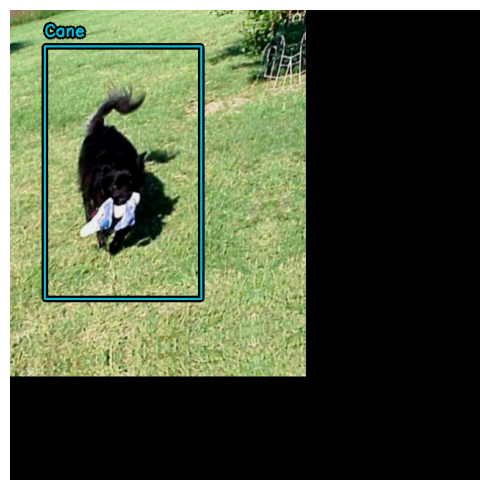

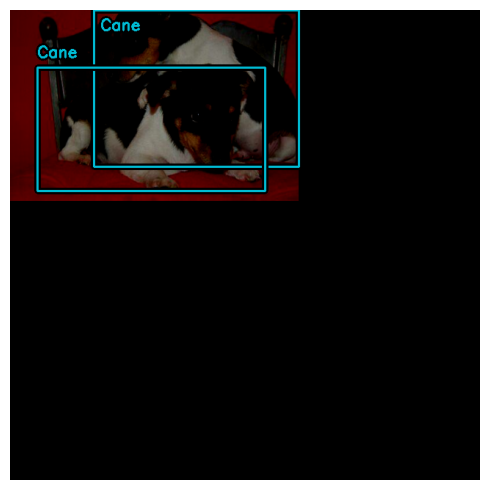

In [29]:

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(2)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=1, cols=1
)

## Check Dataset

In [33]:
# def dict_to_tuple(inputs):
#     return inputs["images"], keras_cv.bounding_box.to_dense(
#         inputs["bounding_boxes"], max_boxes=32
#     )

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

In [34]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    BACKBONE_NAME,  # We will use yolov8 small backbone with coco weights
    load_weights=True
)
backbone.trainable = BACKBONE_TRAINABLE

/home/andrea/tfenvl/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/home/andrea/tfenvl/lib/python3.10/site-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [35]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    #fpn_depth=1
)

## Compile the Model

In [36]:
if os.path.isfile(MODEL_NAME + ".h5"):
    yolo.load_weights(MODEL_NAME + ".h5")

In [37]:
optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

if BACKBONE_UNFREEZE == True:
    backbone.trainable = True

#yolo.summary()
    
# keras.utils.plot_model(
#     yolo,
#     show_trainable=True
#     )
    
trainable_params = 0 
for layer in yolo.trainable_weights:
    trainable_params += layer.numpy().size
print(F"Trainable Params: {trainable_params}")

Trainable Params: 8106950


In [38]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(        
            bounding_box_format="xyxy",
            evaluate_freq=1 #1e9,
        )

        self.save_path = save_path
        self.best_map = bestResult #-1
        #self.best_map = 999

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        tot = self.data.cardinality().numpy()
        i=0
        for batch in self.data:
            i+=1
            print(F"\rCalculate Accuracy Batch {i}/{tot}", end="")
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            y_pred_ragged = bounding_box.to_ragged(y_pred)
            self.metrics.update_state(y_true, y_pred_ragged)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = logs["MaP"]
        #print(F"Calculated MaP: {current_map}")
        #current_map = logs["val_loss"]
        if current_map > self.best_map:
            self.best_map = current_map
            #Save best MaP ti file
            tosave = {"BestMap": self.best_map}
            with open(F'{self.save_path}.pkl', 'wb') as f:
                pickle.dump(tosave, f)
            now = datetime.datetime.now()
            #self.model.save(self.save_path + "-test"+ now.strftime("-%m%d%Y-%H%M%S") + ".h5")
            self.model.save(self.save_path + ".h5")

        return logs


In [39]:
#yolo.save("model_3ep.h5")

In [40]:
# path per i log di TensorBoard
#log_dir = "logs/fit/" + MODEL_NAME + F"-Epoch{INITIAL_EPOCH}-{EPOCH}"# + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + MODEL_NAME
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, write_graph=False)

## Train the Model

In [41]:
# definizione di due callback per migliorare l'addestramento
early_stopping = keras.callbacks.EarlyStopping(monitor="MaP", patience=20, mode='max', verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="MaP", patience=5, factor=0.66, mode='max', min_lr=1.0000e-5, cooldown=5)

#coco_metrics_callback = keras_cv.callbacks.PyCOCOCallback(
#    val_ds.take(2), bounding_box_format="xyxy"
#)

history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), tensorboard_callback, early_stopping]#, early_stopping]
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), tensorboard_callback, reduce_lr]#, early_stopping]
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, MODEL_NAME), reduce_lr]#, early_stopping]
    #callbacks=[coco_metrics_callback, tensorboard_callback, reduce_lr]#, early_stopping]
    #callbacks=[coco_metrics_callback, reduce_lr]#, early_stopping]
)

Epoch 1/100


TypeError: in user code:

    File "/home/andrea/tfenvl/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/andrea/tfenvl/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/andrea/tfenvl/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/andrea/tfenvl/lib/python3.10/site-packages/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_detector.py", line 526, in train_step
        return super().train_step(*args, (x, y))
    File "/home/andrea/tfenvl/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/andrea/tfenvl/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/andrea/tfenvl/lib/python3.10/site-packages/keras/src/backend.py", line 4039, in spatial_2d_padding
        return tf.compat.v1.pad(x, pattern)

    TypeError: Exception encountered when calling layer 'stem_1_pad' (type ZeroPadding2D).
    
    Failed to convert elements of tf.RaggedTensor(values=tf.RaggedTensor(values=Tensor("yolov8_detector/model/rescaling/Add:0", shape=(None, 3), dtype=float32), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None,), dtype=int64)), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(5,), dtype=int64)) to Tensor. Consider casting elements to a supported type. See https://www.tensorflow.org/api_docs/python/tf/dtypes for supported TF dtypes.
    
    Call arguments received by layer 'stem_1_pad' (type ZeroPadding2D):
      • inputs=tf.RaggedTensor(values=tf.RaggedTensor(values=Tensor("yolov8_detector/model/rescaling/Add:0", shape=(None, 3), dtype=float32), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:1", shape=(None,), dtype=int64)), row_splits=Tensor("RaggedFromVariant/RaggedTensorFromVariant:0", shape=(5,), dtype=int64))


In [ ]:
#yolo.save(MODEL_NAME + "_end.h5")

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['box_loss'], label='box_loss')
plt.plot(history.history['class_loss'], label='class_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['val_box_loss'], label='val_box_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.plot(history.history['MaP'], label='MaP')
plt.plot(history.history['MaP@[IoU=50]'], label='MaP IoU=50')
plt.plot(history.history['MaP@[IoU=75]'], label='MaP IoU=75')
plt.plot(history.history['MaP@[area=small]'], label='MaP area small')
plt.plot(history.history['MaP@[area=medium]'], label='MaP area medium')
plt.plot(history.history['MaP@[area=large]'], label='MaP area large')
plt.legend(loc="upper right")
plt.show()

In [ ]:
plt.plot(history.history['Recall@[max_detections=1]'], label='Recall max_detections 1')
plt.plot(history.history['Recall@[max_detections=10]'], label='Recall max_detections 10')
plt.plot(history.history['Recall@[max_detections=100]'], label='Recall max_detections 100')
plt.plot(history.history['Recall@[area=small]'], label='Recall area small')
plt.plot(history.history['Recall@[area=medium]'], label='Recall area medium')
plt.plot(history.history['Recall@[area=large]'], label='Recall area large')
plt.legend(loc="upper right")
plt.show()

In [ ]:
# import pandas
# now = datetime.datetime.now()
# pandas.DataFrame.from_dict(history.history).to_csv(HISTORY_NAME + now.strftime("-%m%d%Y-%H%M%S") + '.csv',index=False)

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")